# Simulate data

This project uses the CMU_ARCTIC database, which is a speech database in CMU_ARCTIC speech synthesis databases, established by the Language Technologies Institute of Carnegie Mellon University, USA. This database is mainly used in the research of speech synthesis. The content of the corpus database was selected by the non-copyright center of Project Gutenberg, which is about 1150 sentences. An audio of two males and two females with American English accents were collected. The recording format is 16 bits, the sampling rate is 32 KHz, and the length of each sentence is 3 seconds. The database has a total of 4528 audio files.

## Imports

In [11]:
import math
import sys
import os
import matplotlib
from collections import defaultdict

import numpy as np
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import fft
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pyroomacoustics as pra
from pyroomacoustics.utilities import normalize

import matplotlib.pyplot as plt

## Constants

In [12]:
# Label resolution of angles
RESOLUTION = 10

# Training rooms dimensions
ROOMS = {
    'small' : np.array([4, 4, 2]),
    'medium' : np.array([6, 6, 2]),
    'large' : np.array([8, 8, 2])
}

# Testing rooms dimensions
TEST_ROOMS = {
    #'small' : np.array([5, 5, 2]),
    'medium' : np.array([7, 7, 2]),
    #'large' : np.array([9, 9, 2])
}

class Path:
    def __init__(self, name, path, max_angle):
        self.name = name
        self.path = path
        self.max_angle = max_angle

AUDIO_PATH = [
    #Path('full', 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\full_circle', 360),
    Path('half', 'C:\\Users\\Alex\\source\\repos\\sound-localization\\data\\half_circle', 180)
]

AUDIO_FILES = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

'''
    snr factor:
    - 0.1   -> SNR = 10dB
    - 0.01  -> SNR = 20dB
    - 0.001 -> SNR = 30dB
'''
SNR_FACTOR = [0.001]

## Definition for rooms, microphones and sources

In [13]:
def create_simulation_room(room_dim=[4, 4, 2], mic_pos=[2, 2, 0], room_fs=16000, noise=math.nan):    
    # Initialize room
    if math.isnan(noise):
        room = pra.ShoeBox(room_dim, fs=room_fs, max_order=0)
    else:
        room = pra.ShoeBox(room_dim, fs=room_fs, max_order=2)
    
    w = room_dim[0]
    l = room_dim[1]
    h = room_dim[2]

    # Generate the microphones
    mic_pos = np.c_[[w/2+0.1, l/2, h/2],[w/2-0.1, l/2, h/2]] 
    room.add_microphone_array(mic_pos)
    
    return room


def create_sound_sources(max_angle, room_dim=[4, 4, 2], resolution=RESOLUTION):        
    # Specify angle in distance ranges
    if max_angle == 180 : max_angle += 1
    angle_range = range(0, max_angle, resolution)
    dist_range = [1., 2.]
    height_range = [room_dim[-1]/2]
    sources = defaultdict(list)

    for angle in angle_range:
        for R in dist_range:
            for h in height_range:
                source = [R * math.cos(math.radians(angle)) + room_dim[0] / 2, 
                            R * math.sin(math.radians(angle)) + room_dim[1] / 2, h]
                sources[angle].append((R, h, source))
    return sources


def simulate_room(audio_file, subset, path, room_type='small', mic_pos=[2, 2, 0], label_res=20, snr_factor=math.nan):
    file_name = os.path.basename(audio_file).split('.')[0]

    # Read the audio file
    sample_rate, samples = wavfile.read(audio_file)
    
    # Get room dimensions
    if subset == 'train':
        room_dim = ROOMS[room_type]
    else:
        room_dim = TEST_ROOMS[room_type]

    # Create all sound sources
    sources = create_sound_sources(path.max_angle, room_dim)

    # Check RT60
    rt60 = []

    # Simulate every sound source that was created before
    for angle, sources in sources.items():
        if angle % label_res == 0:
            print(f'\nSimulating {angle}-{angle + label_res - 1} degrees:', end=' ')
            
        sys.stdout.write("#")
        
        wav_signals = defaultdict(list)
        
        for dist, height, source in sources:
            room = create_simulation_room(room_dim=room_dim, mic_pos=mic_pos, room_fs=sample_rate, noise=snr_factor)
            room.add_source(source, signal=samples, delay=0.0)

            if math.isnan(snr_factor):
                room.simulate()
            else:
                snr = 10*math.log10(room.n_mics/snr_factor)
                room.simulate(reference_mic=0, snr=snr)
                t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=False)
                rt60.append(t60)

            # Extract simulated signal for each microphone
            data = room.mic_array.signals.T
            data = np.array(normalize(data, bits=16), dtype=np.int16)
            
            # Append simulated data to the final WAV signals
            wav_signals[dist].extend(data)
            
        # Save WAV files containing 2 channel data for all distances at given angle
        for dist in wav_signals:
            save_name = f'{subset}_angle_{angle}_dist_{int(dist*100)}_room_{room_type}_{file_name}.wav'
            string_snr = str(snr_factor)
            wavfile.write(f'{path.path}/{string_snr}/{save_name}', 16000, np.array(wav_signals[dist]))
            
    if math.isnan(snr_factor) == False:
        print(f"\nThe RT60 is {np.mean(rt60) * 1000:.0f} ms")
            
    print('\nSimulation successful!')

## Run simulations

In [14]:
for snr_factor in SNR_FACTOR:
    print(f'SNR factor: {snr_factor}')

    for path in AUDIO_PATH:
        print(f'Source type: {path.name}')

        print('Simulating training data:')
        for each in AUDIO_FILES:
            file = 'arctic_a00' + each + '.wav'

            print(f'File: {file}')
            for room, dim in ROOMS.items():
                print(f'Room: {room}')
                sound_files = f"C:\\Users\\Alex\\source\\repos\\Data\\Sound\\{file}"
                simulate_room(sound_files, 'train', path, room, dim / 2, label_res=90, snr_factor=snr_factor)


        print('Simulating validation data:')
        for room, dim in TEST_ROOMS.items():
            print(f'Room: {room}')
            sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0100.wav"
            simulate_room(sound_files, 'validation', path, room, dim / 2, label_res=90, snr_factor=snr_factor)


        print('Simulating test data:')
        for room, dim in TEST_ROOMS.items():
            print(f'Room: {room}')
            sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0200.wav"
            simulate_room(sound_files, 'test', path, room, dim / 2, label_res=90, snr_factor=snr_factor)


SNR factor: 0.001
Source type: half
Simulating training data:
File: arctic_a0001.wav
Room: small

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #
The RT60 is 17 ms

Simulation successful!
Room: medium

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #
The RT60 is 28 ms

Simulation successful!
Room: large

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #
The RT60 is 41 ms

Simulation successful!
File: arctic_a0002.wav
Room: small

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #
The RT60 is 17 ms

Simulation successful!
Room: medium

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 degrees: #
The RT60 is 28 ms

Simulation successful!
Room: large

Simulating 0-89 degrees: #########
Simulating 90-179 degrees: #########
Simulating 180-269 d

## Check output

In [15]:
sound_file = os.path.join(AUDIO_PATH[1].path, "test_angle_0_dist_100_room_large_arctic_a0016.wav")

sample_rate, samples = wavfile.read(sound_file)
cols = [f'mic_{i}' for i in range(2)]
df = pd.DataFrame(data=samples, columns=cols, dtype=np.int16)
df.iloc[2000:2005]

IndexError: list index out of range

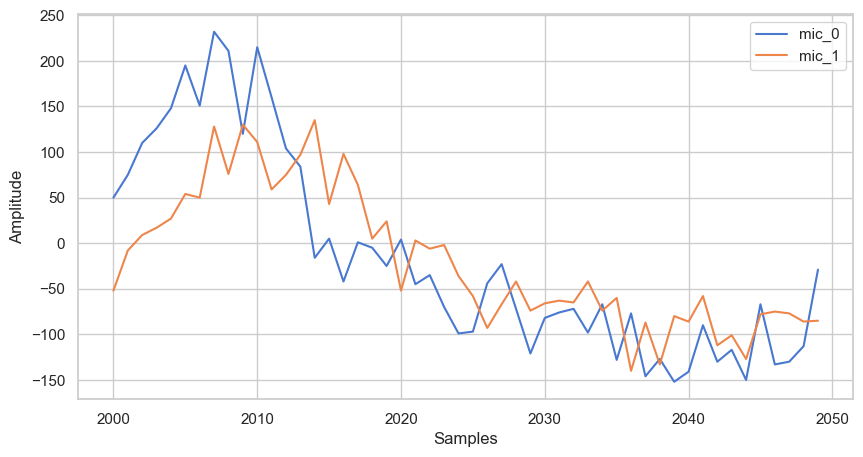

In [ ]:
sns.set(style='whitegrid', palette='muted', font_scale=1)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Amplitude')
ax.set_xlabel('Samples')
df.iloc[2000:2050].plot(ax=ax)
plt.show()

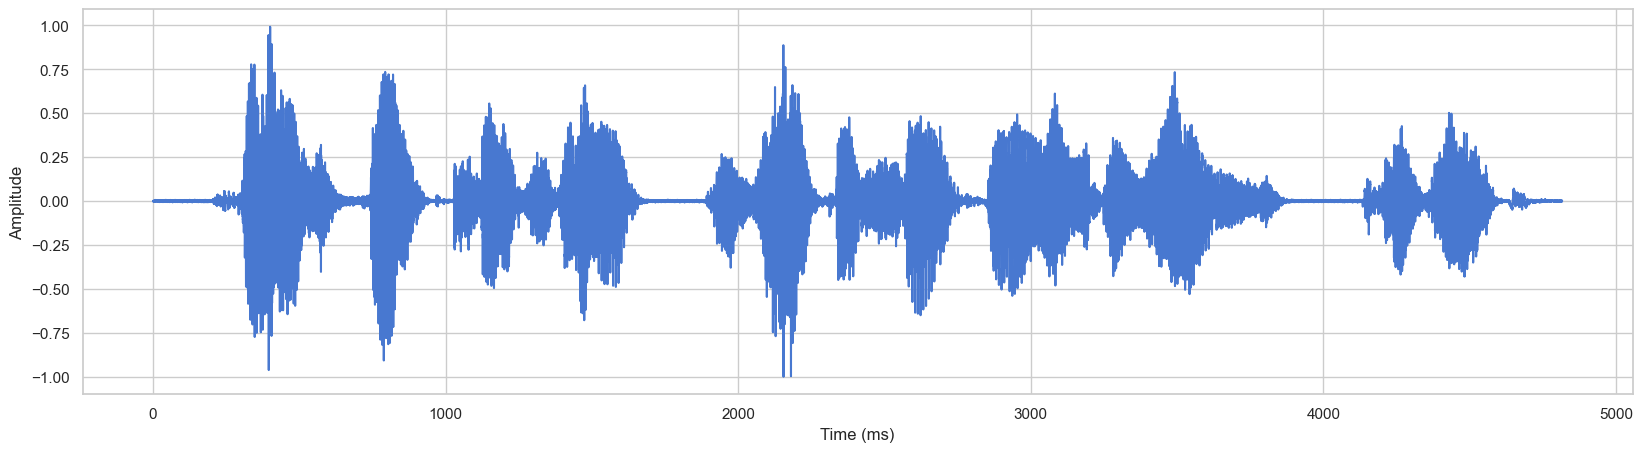

NameError: name 'freq_array' is not defined

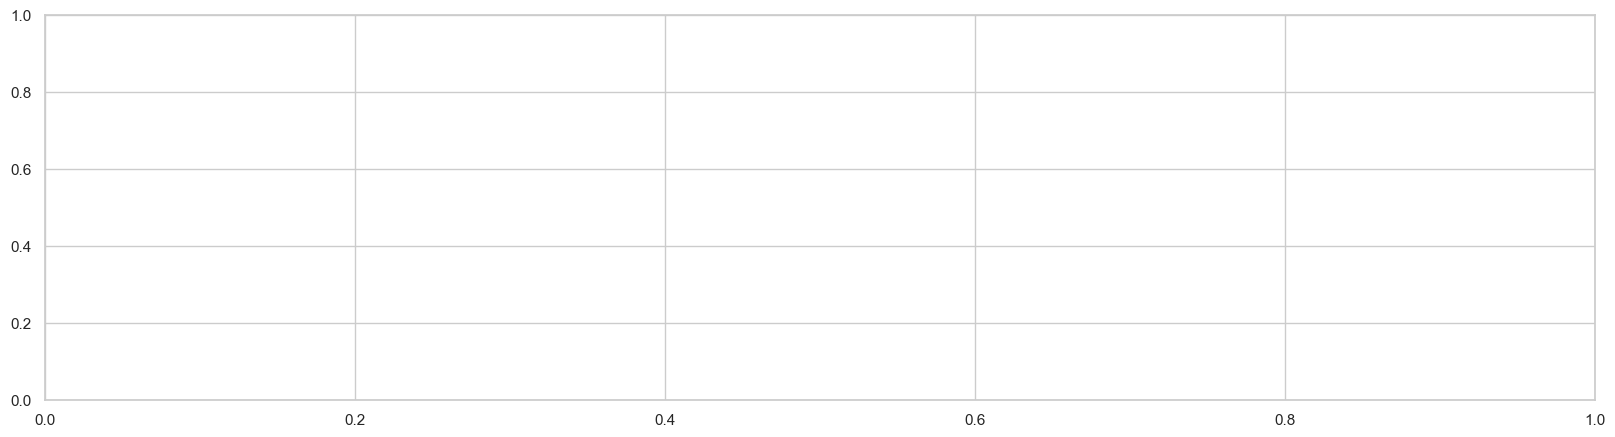

In [ ]:
# Convert sound array to floating point values ranging from -1 to 1 as follows
sample_rate, samples = wavfile.read(sound_file)
sound = samples / (2.**15)

# Select first channel
sound_channel = sound[:,0]

# Create an array of sample point in one dimension
time_array = np.arange(0, float(sound.shape[0]), 1)
time_array = (time_array / sample_rate) * 1000 # scale to milliSeconds

# Plot the tone
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(time_array, sound_channel)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()


# Get frequency from amplitude and time using FFT, Fast Fourier Transform algorithm
sound_lenght = len(sound)
fft_array = fft(sound_channel)
num_unique_points = np.ceil((sound_lenght + 1) / 2.0)
fft_array = fft_array[0:int(num_unique_points)]

# FFT contains both magnitude and phase and given in complex numbers in real + imaginary parts (a + ib) format.
# Get real part By taking absolute value
fft_array = abs(fft_array)

# Scale the fft array by length of sample points so that magnitude does not depend on
# the length of the signal or on its sampling frequency
fft_array = fft_array / float(sound_lenght)

# Plot the frequency
fig, ax = plt.subplots(figsize=(20, 5))
plt.plot(freq_array/1000, 10 * np.log10 (fft_array))
plt.xlabel('Frequency (Khz)')
plt.ylabel('Power (dB)')
plt.show()

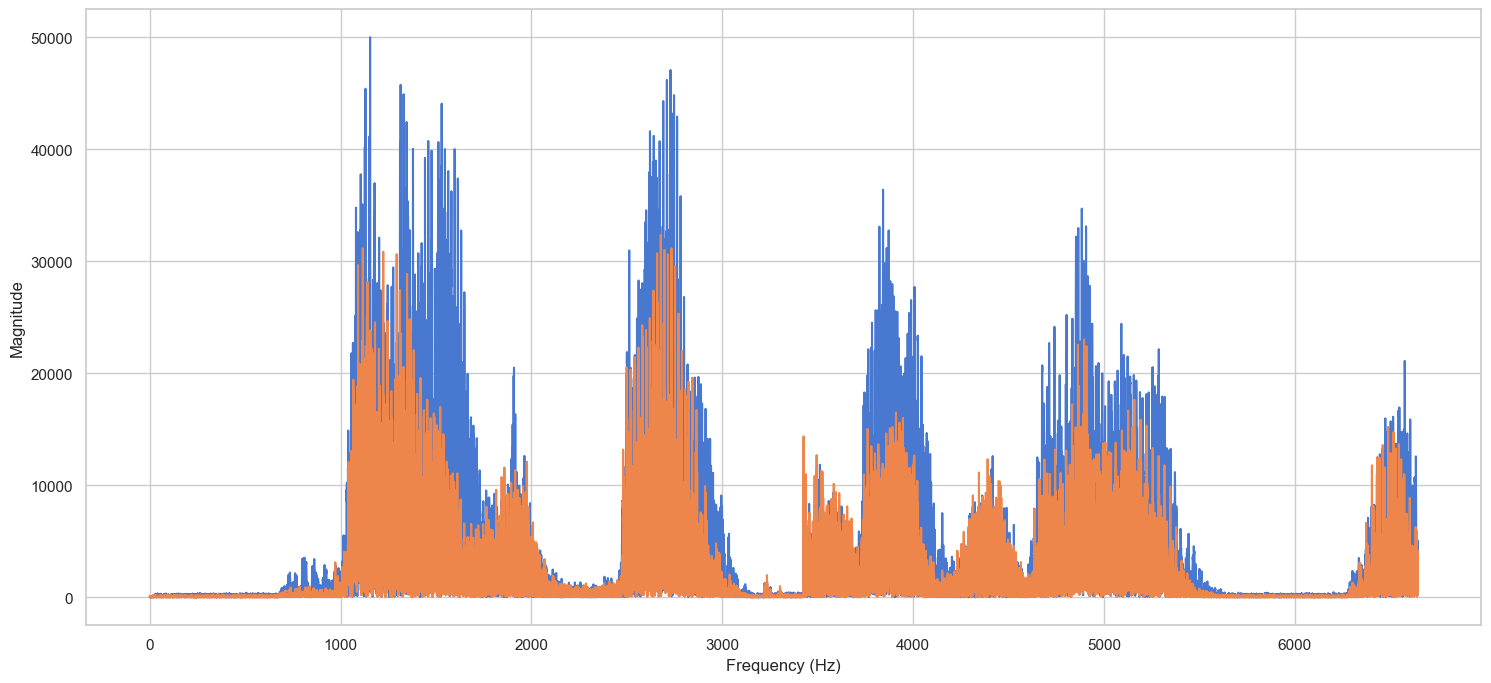

77052
6.25e-05


In [ ]:
sample_rate, samples = wavfile.read(sound_file)

ft = fft(samples)
magnitude = np.abs(ft)
frequency = np.linspace(0, sample_rate, len(magnitude))

plt.figure(figsize=(18,8))
plt.plot(frequency[:32000], magnitude[:32000])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

print(len(samples))
print(1/sample_rate)

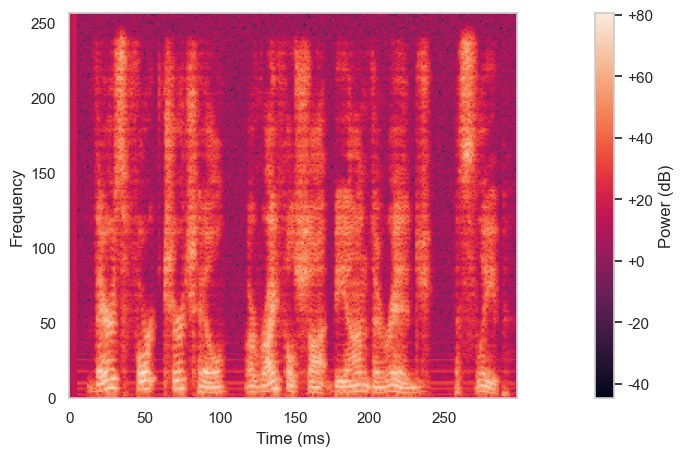

In [ ]:
# Get the time-frequency domain as the Short Time Fourier Transforms
sample_rate, samples = wavfile.read(sound_file)

# Select first channel
samples = samples[:,0]

frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate, nfft=512, noverlap=256, nperseg=512, scaling='spectrum')
spec_dB = 10 * np.log10(spectrogram)  # convert to dB

# Plot spectogram
norm=matplotlib.colors.LogNorm(vmin=np.amin(spectrogram), vmax=np.amax(spectrogram))

fig, ax = plt.subplots(figsize=(20, 5))
plt.pcolormesh(times, frequencies, spec_dB, norm=norm, shading='auto')
plt.imshow(spec_dB)
ax.invert_yaxis()
plt.ylabel('Frequency')
plt.xlabel('Time (ms)')
plt.colorbar(format="%+2.f", label='Power (dB)')
plt.show()

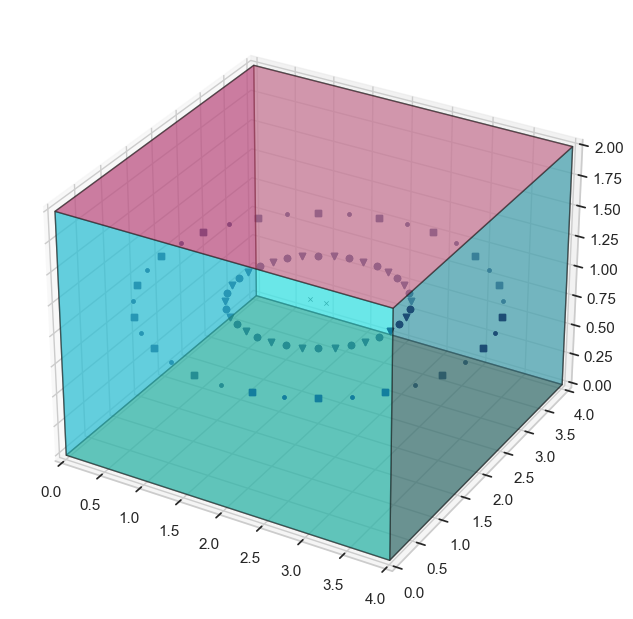

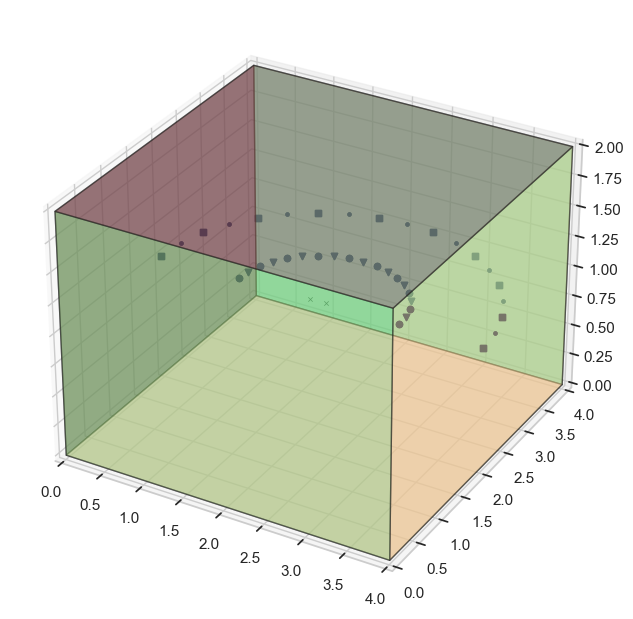

In [ ]:
room_dim = ROOMS['small']
sound_files = "C:\\Users\\Alex\\source\\repos\\Data\\Sound\\arctic_a0014.wav"

for path in AUDIO_PATH:
    room = create_simulation_room(room_dim, mic_pos=room_dim / 2)
    sources = create_sound_sources(path.max_angle, room_dim)

    def plot_room(room, sources, signal):
        # Add every single source to the room
        for angle, sources in sources.items():
            for _, _, source in sources:
                room.add_source(source, signal=signal, delay=0.5)

        # Plot the room
        fig, ax = room.plot()
        fig.set_size_inches(6, 6)
        ax.set_xlim([0, room_dim[0]])
        ax.set_ylim([0, room_dim[1]])
        ax.set_zlim([0, room_dim[2]])
        
    plot_room(room, sources, sound_files)